In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import json
import random
import seaborn as sns
import re

import spacy

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

import librosa

# ### Scikit-Learn ###
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skmetrics

import scipy.stats as stats
from sklearn import linear_model
from sklearn.metrics import r2_score

from pyannote.audio.pipelines import VoiceActivityDetection

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     D:\Usuarios\jllajur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Usuarios\jllajur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
torchvision is not available - cannot save figures
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


In [2]:
config_json = open("../LableniBotConfig/config.json")
config_dict = json.load(config_json)

hugging_face_key = config_dict["HUGGING_FACE"]

silence_detection_pipeline = VoiceActivityDetection(segmentation="pyannote/segmentation",
                                                    use_auth_token=hugging_face_key)

In [5]:
conv_idx = random.choices(np.arange(20), k=1)[0]
personality_idx = random.choices(np.arange(6), k=1)[0]

all_conv = os.listdir("../Conversations/")
all_personality = os.listdir("../Conversations/" + all_conv[conv_idx])
path_to_audios = "../Conversations/" + all_conv[conv_idx] + "/" + all_personality[2:][personality_idx] + "/Audios/"
list_of_audios = os.listdir(path_to_audios)
all_subj_audios_idx = random.choices(np.arange(len(list_of_audios)), k=1)[0]
path_to_audio_study = path_to_audios + list_of_audios[all_subj_audios_idx]
path_to_audio_study

'../Conversations/User_04_CB2_Conversations/User_04_CB2_20230201_102147/Audios/Subject_User_04_CB2_T=1.wav'

In [6]:
audio_duration = librosa.get_duration(filename=path_to_audio_study)
        
vad = silence_detection_pipeline(path_to_audio_study)
segments_timeline = list(vad.get_timeline().segments_set_)

first_start = np.min([seg.start for seg in segments_timeline])
last_end = np.max([seg.end for seg in segments_timeline])
num_talk_stops = len(segments_timeline)-1

time_waste_silence = audio_duration - last_end
time_talking = last_end - first_start
perc_talking_audio = 100 * time_talking/audio_duration

result_dict = {
    "AudioDuration": audio_duration,
    "FirstStart": first_start,
    "LastEnd": last_end,
    "NumTalks": num_talk_stops,
    "TimeWasteSilence": time_waste_silence,
    "TimeTalking": time_talking,
    "PercTalkingAudio": perc_talking_audio,
}

print(result_dict)

{'AudioDuration': 5.828208616780046, 'FirstStart': 1.3584375, 'LastEnd': 5.7796875, 'NumTalks': 0, 'TimeWasteSilence': 0.048521116780046114, 'TimeTalking': 4.42125, 'PercTalkingAudio': 75.85950144733565}


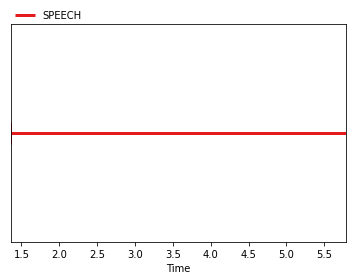

In [7]:
vad

In [9]:
all_conv[conv_idx]

'User_02_CB__Conversations'

In [4]:
num_iter, counter = 50, 0
result_audio_list = [] 
while True:
    try:
        conv_idx = random.choices(np.arange(20), k=1)[0]
        personality_idx = random.choices(np.arange(6), k=1)[0]

        all_conv = os.listdir("../Conversations/")
        all_personality = os.listdir("../Conversations/" + all_conv[conv_idx])
        path_to_audios = "../Conversations/" + all_conv[conv_idx] + "/" + all_personality[2:][personality_idx] + "/Audios/"
        list_of_audios = os.listdir(path_to_audios)
        all_subj_audios_idx = random.choices(np.arange(len(list_of_audios)), k=1)[0]
        path_to_audio_study = path_to_audios + list_of_audios[all_subj_audios_idx]

        audio_duration = librosa.get_duration(filename=path_to_audio_study)

        vad = silence_detection_pipeline(path_to_audio_study)
        segments_timeline = list(vad.get_timeline().segments_set_)

        first_start = np.min([seg.start for seg in segments_timeline])
        last_end = np.max([seg.end for seg in segments_timeline])
        num_talk_stops = len(segments_timeline)-1

        time_waste_silence = audio_duration - last_end
        time_talking = last_end - first_start
        perc_talking_audio = 100 * time_talking/audio_duration

        result_audio_list.append({
            "AudioDuration": audio_duration,
            "FirstStart": first_start,
            "LastEnd": last_end,
            "NumTalks": num_talk_stops,
            "TimeWasteSilence": time_waste_silence,
            "TimeTalking": time_talking,
            "PercTalkingAudio": perc_talking_audio,
            "AudioPath": all_personality[2:][personality_idx] + list_of_audios[all_subj_audios_idx]
        })

        counter += 1
    except:
        pass
    
    if counter >= num_iter:
            break

In [38]:
df_audio = pd.DataFrame(result_audio_list)

In [39]:
df_audio

,AudioDuration,FirstStart,LastEnd,NumTalks,TimeWasteSilence,TimeTalking,PercTalkingAudio,AudioPath
0,9.125442,0.008438,6.910312,0,2.215130,6.901875,75.633321,../Conversations/USER_08_CB2_Conversations/USE...
1,5.944308,0.869063,2.202187,0,3.742121,1.333125,22.426915,../Conversations/User_08_CB_Conversations/User...
2,5.990748,2.016563,4.834687,0,1.156061,2.818125,47.041285,../Conversations/USER_02_CB2_Conversations/USE...
3,5.990748,0.008438,0.784688,0,5.206061,0.776250,12.957480,../Conversations/USER_09_CB2_Conversations/USE...
4,12.260136,0.734063,9.374063,0,2.886074,8.640000,70.472301,../Conversations/User_09_CB_Conversations/User...
5,24.775692,1.139063,24.730313,1,0.045379,23.591250,95.219340,../Conversations/User_04_CB_Conversations/User...
6,5.990748,0.008438,4.716563,0,1.274186,4.708125,78.589932,../Conversations/USER_02_CB2_Conversations/USE...
7,5.944308,0.885938,3.653438,0,2.290871,2.767500,46.557140,../Conversations/User_03_CB_Conversations/User...
8,9.125442,0.666563,6.387187,1,2.738255,5.720625,62.688743,../Conversations/USER_09_CB2_Conversations/USE...
9,5.967528,1.004063,1.577813,0,4.389716,0.573750,9.614533,../Conversations/User_06_CB_Conversations/User...


In [40]:
df_audio["AudioPath"].iloc[0]

'../Conversations/USER_08_CB2_Conversations/USER_08_CB2_20230202_125214/Audios/Subject_USER_08_CB2_T=1.wav'

In [41]:
df_audio[df_audio["LastEnd"] > 5]["TimeWasteSilence"].mean()

2.3201030868696684

In [42]:
df_audio["TimeWasteSilence"].mean()

2.6844264739229016

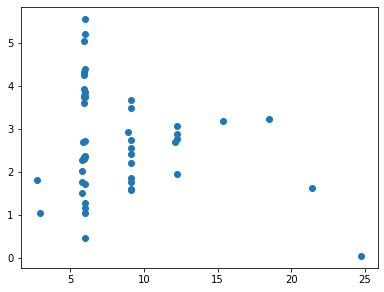

In [43]:
plt.scatter(df_audio["AudioDuration"], df_audio["TimeWasteSilence"])

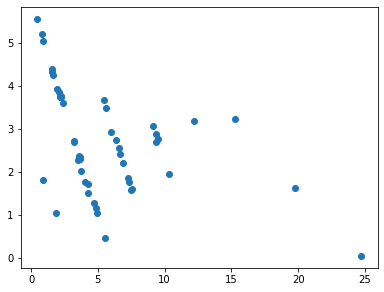

In [44]:
plt.scatter(df_audio["LastEnd"], df_audio["TimeWasteSilence"])

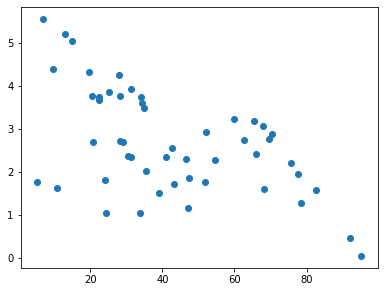

In [7]:
list_of_audios[all_subj_audios_idx].split("=")[-1].split(".")[0]

'3'

In [8]:
all_personality

['GuideOfTimes.csv',
 'GuideOfTimes.pkl',
 'User_02_CB_20221116_115212',
 'User_02_CB_20221116_120328',
 'User_02_CB_20221116_121231',
 'User_02_CB_20221116_122202',
 'User_02_CB_20221116_123151',
 'User_02_CB_20221116_123302',
 'User_02_CB_20221116_123945']

In [10]:

result_audio_list = []

for i_conv, all_conv in enumerate(os.listdir("../Conversations/")):
    
    print("Iteration", i_conv, end="\r")
    
    all_personalities = [name for name in os.listdir("../Conversations/" + all_conv) if "." not in name]
    for vh_pers in all_personalities:
        path_to_audios = "../Conversations/" + all_conv + "/" + vh_pers + "/Audios/"
        for audio in os.listdir(path_to_audios):
            audio_id = audio.split("=")[-1].split(".")[0]
            whole_audio_path = path_to_audios + audio
            try:
                audio_duration = librosa.get_duration(filename=whole_audio_path)

                vad = silence_detection_pipeline(whole_audio_path)
                segments_timeline = list(vad.get_timeline().segments_set_)

                first_start = np.min([seg.start for seg in segments_timeline])
                last_end = np.max([seg.end for seg in segments_timeline])
                num_talk_stops = len(segments_timeline)-1

                time_waste_silence = audio_duration - last_end
                time_talking = last_end - first_start
                perc_talking_audio = 100 * time_talking/audio_duration

                result_audio_list.append({
                    "AudioPosition": int(audio_id),
                    "Subject": all_conv,
                    "Personality": vh_pers,
                    "AudioDuration": audio_duration,
                    "FirstStart": first_start,
                    "LastEnd": last_end,
                    "NumTalks": num_talk_stops,
                    "TimeWasteSilence": time_waste_silence,
                    "TimeTalking": time_talking,
                    "PercTalkingAudio": perc_talking_audio,
                    "AudioPath": all_personality[2:][personality_idx] + list_of_audios[all_subj_audios_idx]
                })
            except:
                pass


In [12]:
df_result_audio = pd.DataFrame(result_audio_list)

In [28]:
print(df_result_audio.shape)

(5970, 12)


In [25]:
more_data_to_audio = []
for idx_pos in df_result_audio.index:
    subj_folder = df_result_audio["Subject"].loc[idx_pos]
    pty_folder = df_result_audio["Personality"].loc[idx_pos]
    keep_date = "_".join(pty_folder.split("_")[-2:])
    
    conv_file = "Conv_" + keep_date + ".csv"
    
    try:
        path_to_data = "../Conversations/" + subj_folder + "/" + pty_folder + "/" + conv_file

        df_data = pd.read_csv(path_to_data, sep=";")
        personality, gender, id_vh = df_data["ConfigName"].iloc[0].split("_")

        more_data_to_audio.append({
            "Date": keep_date,
            "Personality": personality,
            "Gender": gender,
            "IDVH": id_vh
        })
    except:
        
        more_data_to_audio.append({
            "Date": np.nan,
            "Personality": np.nan,
            "Gender": np.nan,
            "IDVH": np.nan
        })
        
        print("Bad subject", path_to_data)
        continue

Bad subject ../Conversations/User_45_CB_Conversations/User_45_CB_20221215_141244/Conv_20221215_141244.csv
Bad subject ../Conversations/User_45_CB_Conversations/User_45_CB_20221215_143002/Conv_20221215_143002.csv
Bad subject ../Conversations/User_50_CB_Conversations/User_50_CB_20221219_144734/Conv_20221219_144734.csv
Bad subject ../Conversations/User_50_CB_Conversations/User_50_CB_20221219_144734/Conv_20221219_144734.csv
Bad subject ../Conversations/User_50_CB_Conversations/User_50_CB_20221219_144734/Conv_20221219_144734.csv
Bad subject ../Conversations/User_50_CB_Conversations/User_50_CB_20221219_144734/Conv_20221219_144734.csv
Bad subject ../Conversations/User_50_CB_Conversations/User_50_CB_20221219_144734/Conv_20221219_144734.csv
Bad subject ../Conversations/User_50_CB_Conversations/User_50_CB_20221219_144734/Conv_20221219_144734.csv


In [27]:
df_more_data = pd.DataFrame(more_data_to_audio)
print("More data shape", df_more_data.shape)

More data shape (5970, 4)


In [33]:
df_result_merge = pd.concat([df_result_audio, df_more_data], axis=1)
df_result_merge = df_result_merge.dropna().reset_index(drop=True)

In [35]:
df_result_merge

,AudioPosition,Subject,Personality,AudioDuration,FirstStart,LastEnd,NumTalks,TimeWasteSilence,TimeTalking,PercTalkingAudio,AudioPath,SubjNameUser,Date,Personality,Gender,IDVH
0,0,USER_01_CB2_Conversations,USER_01_CB2_20230131_100202,5.967528,0.008438,1.425938,0,4.541591,1.417500,23.753553,User_02_CB_20221116_120328Subject_User_02_CB_T...,USER_01_CB2,20230131_100202,Neutral,Female,1
1,1,USER_01_CB2_Conversations,USER_01_CB2_20230131_100202,5.990748,0.464062,3.535313,0,2.455436,3.071250,51.266550,User_02_CB_20221116_120328Subject_User_02_CB_T...,USER_01_CB2,20230131_100202,Neutral,Female,1
2,10,USER_01_CB2_Conversations,USER_01_CB2_20230131_100202,15.371610,0.008438,11.415938,0,3.955672,11.407500,74.211485,User_02_CB_20221116_120328Subject_User_02_CB_T...,USER_01_CB2,20230131_100202,Neutral,Female,1
3,11,USER_01_CB2_Conversations,USER_01_CB2_20230131_100202,9.125442,0.497812,7.686563,0,1.438880,7.188750,78.777005,User_02_CB_20221116_120328Subject_User_02_CB_T...,USER_01_CB2,20230131_100202,Neutral,Female,1
4,12,USER_01_CB2_Conversations,USER_01_CB2_20230131_100202,12.236916,0.717187,9.981563,0,2.255354,9.264375,75.708413,User_02_CB_20221116_120328Subject_User_02_CB_T...,USER_01_CB2,20230131_100202,Neutral,Female,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5957,5,User_52_CB_Conversations,User_52_CB_20221221_103754,9.102222,2.100938,5.425313,0,3.676910,3.324375,36.522675,User_02_CB_20221116_120328Subject_User_02_CB_T...,User_52_CB,20221221_103754,Relax,Woman,2
5958,6,User_52_CB_Conversations,User_52_CB_20221221_103754,12.260136,0.970313,9.036563,1,3.223574,8.066250,65.792500,User_02_CB_20221116_120328Subject_User_02_CB_T...,User_52_CB,20221221_103754,Relax,Woman,2
5959,7,User_52_CB_Conversations,User_52_CB_20221221_103754,12.236916,1.375313,9.711562,0,2.525354,8.336250,68.123782,User_02_CB_20221116_120328Subject_User_02_CB_T...,User_52_CB,20221221_103754,Relax,Woman,2
5960,8,User_52_CB_Conversations,User_52_CB_20221221_103754,12.236916,2.151562,9.559688,0,2.677229,7.408125,60.539150,User_02_CB_20221116_120328Subject_User_02_CB_T...,User_52_CB,20221221_103754,Relax,Woman,2


In [36]:
subj_name_user_list = [
    s_n.replace("_Conversations", "").replace("User", "USER") for s_n in df_result_merge["Subject"].values
]
df_result_merge["SubjNameUser"] = subj_name_user_list

In [37]:
df_result_merge.to_csv("Results/AudioProcessedData.csv", index=False, sep=";")

In [38]:
df_result_audio = pd.read_csv("Results/AudioProcessedData.csv", sep=";")

In [39]:
with open('Results/NoDepressSubjects.txt', 'r') as f:
    subj_no_depress_list = f.readlines()
subj_no_depress_list = [subj.replace("\n", "") for subj in subj_no_depress_list]

In [40]:
all_subj_list = []
for subj, df_subj in df_result_audio.groupby("SubjNameUser"):
    if subj in subj_no_depress_list:
        all_subj_list.append(df_subj)
        
df_no_depress = pd.concat(all_subj_list).reset_index(drop=True)

In [41]:
print("Subj no depress", df_no_depress.shape)

Subj no depress (3736, 16)


In [42]:
aute.stat_print(df_no_depress["FirstStart"], "Start audio (s)")
aute.stat_print(df_no_depress["LastEnd"], "Time to end audio (s)")
aute.stat_print(df_no_depress["AudioDuration"], "Audio duration (s)")
aute.stat_print(df_no_depress["NumTalks"], "Number of stops (s)")
aute.stat_print(df_no_depress["TimeWasteSilence"], "Time waste silence pipeline (s)")
aute.stat_print(df_no_depress[df_no_depress["LastEnd"] > 5]["TimeWasteSilence"], "Time waste silence pipeline (s) above 5s")
aute.stat_print(df_no_depress[df_no_depress["TimeTalking"] != 0]["TimeTalking"], "Time talking (s)")
aute.stat_print(df_no_depress["PercTalkingAudio"], "Perc talking (s)")

Mean Start audio (s) = 1.2731 +/- 1.9121 ; Median = 0.8606 ; Min. =  0.0084 ; Max. =  28.1222
Mean Time to end audio (s) = 5.2084 +/- 4.0947 ; Median = 4.2441 ; Min. =  0.1941 ; Max. =  29.9278
Mean Audio duration (s) = 8.0097 +/- 3.6579 ; Median = 5.9907 ; Min. =  2.7167 ; Max. =  29.977
Mean Number of stops (s) = 0.1539 +/- 0.4062 ; Median = 0.0 ; Min. =  0 ; Max. =  4
Mean Time waste silence pipeline (s) = 2.8013 +/- 1.2949 ; Median = 2.8134 ; Min. =  0.0407 ; Max. =  8.385
Mean Time waste silence pipeline (s) above 5s = 2.2492 +/- 1.1078 ; Median = 2.4136 ; Min. =  0.0407 ; Max. =  6.0016
Mean Time talking (s) = 3.9353 +/- 3.6648 ; Median = 2.7675 ; Min. =  0.1688 ; Max. =  27.3713
Mean Perc talking (s) = 44.0348 +/- 23.3214 ; Median = 42.5322 ; Min. =  2.1834 ; Max. =  99.7828


In [43]:
summary_audio_list = []
for k, df_k in df_no_depress.groupby("AudioPosition"):
    
    if df_k.shape[0] <= 3:
        continue
    
    summary_audio_list.append({
        "AudioPosition": k,
        "MeanWasteSilence": df_k["TimeWasteSilence"].mean(),
        "StdWasteSilence": df_k["TimeWasteSilence"].std(),
        "MeanAudioDuration": df_k["AudioDuration"].mean(),
        "StdAudioDuration": df_k["AudioDuration"].std(),
    })
    
df_sum_audio = pd.DataFrame(summary_audio_list)

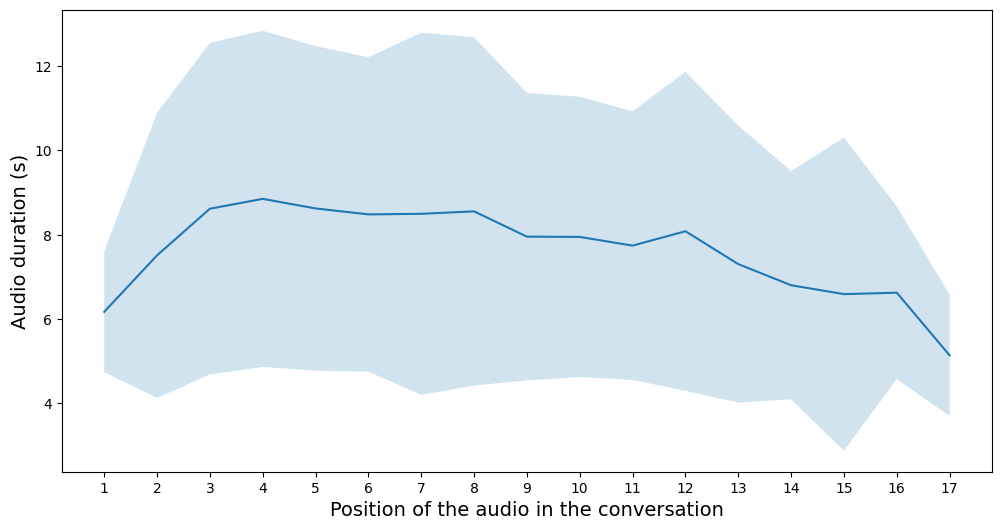

In [45]:
'''
plt.figure(figsize=(12, 6))

plt.plot(df_sum_audio["AudioPosition"]+1, df_sum_audio["MeanWasteSilence"])
plt.fill_between(df_sum_audio["AudioPosition"]+1, 
                 df_sum_audio["MeanWasteSilence"]-df_sum_audio["StdWasteSilence"], 
                 df_sum_audio["MeanWasteSilence"]+df_sum_audio["StdWasteSilence"], 
                 alpha=0.2)

plt.xlabel("Position of the audio in the conversation", fontsize=14)
plt.ylabel("Time to cut the recording (s)", fontsize=14)

plt.xticks(np.arange(1, df_sum_audio.shape[0]+1), np.arange(1, df_sum_audio.shape[0]+1))

plt.savefig("Results/TimevsPosition.pdf", dpi=300, format="pdf")
'''

plt.figure(figsize=(12, 6))

plt.plot(df_sum_audio["AudioPosition"]+1, df_sum_audio["MeanAudioDuration"])
plt.fill_between(df_sum_audio["AudioPosition"]+1, 
                 df_sum_audio["MeanAudioDuration"]-df_sum_audio["StdAudioDuration"], 
                 df_sum_audio["MeanAudioDuration"]+df_sum_audio["StdAudioDuration"], 
                 alpha=0.2)

plt.xlabel("Position of the audio in the conversation", fontsize=14)
plt.ylabel("Audio duration (s)", fontsize=14)

plt.xticks(np.arange(1, df_sum_audio.shape[0]+1), np.arange(1, df_sum_audio.shape[0]+1))

plt.savefig("Results/DurationvsPosition.pdf", dpi=300, format="pdf")

# plt.show()

Correlation value -0.48091182063154664
P-value ***
Coefficients: 
 [-0.15130021] 
Intercept: 
 3.60248050912525
R-square: 0.23


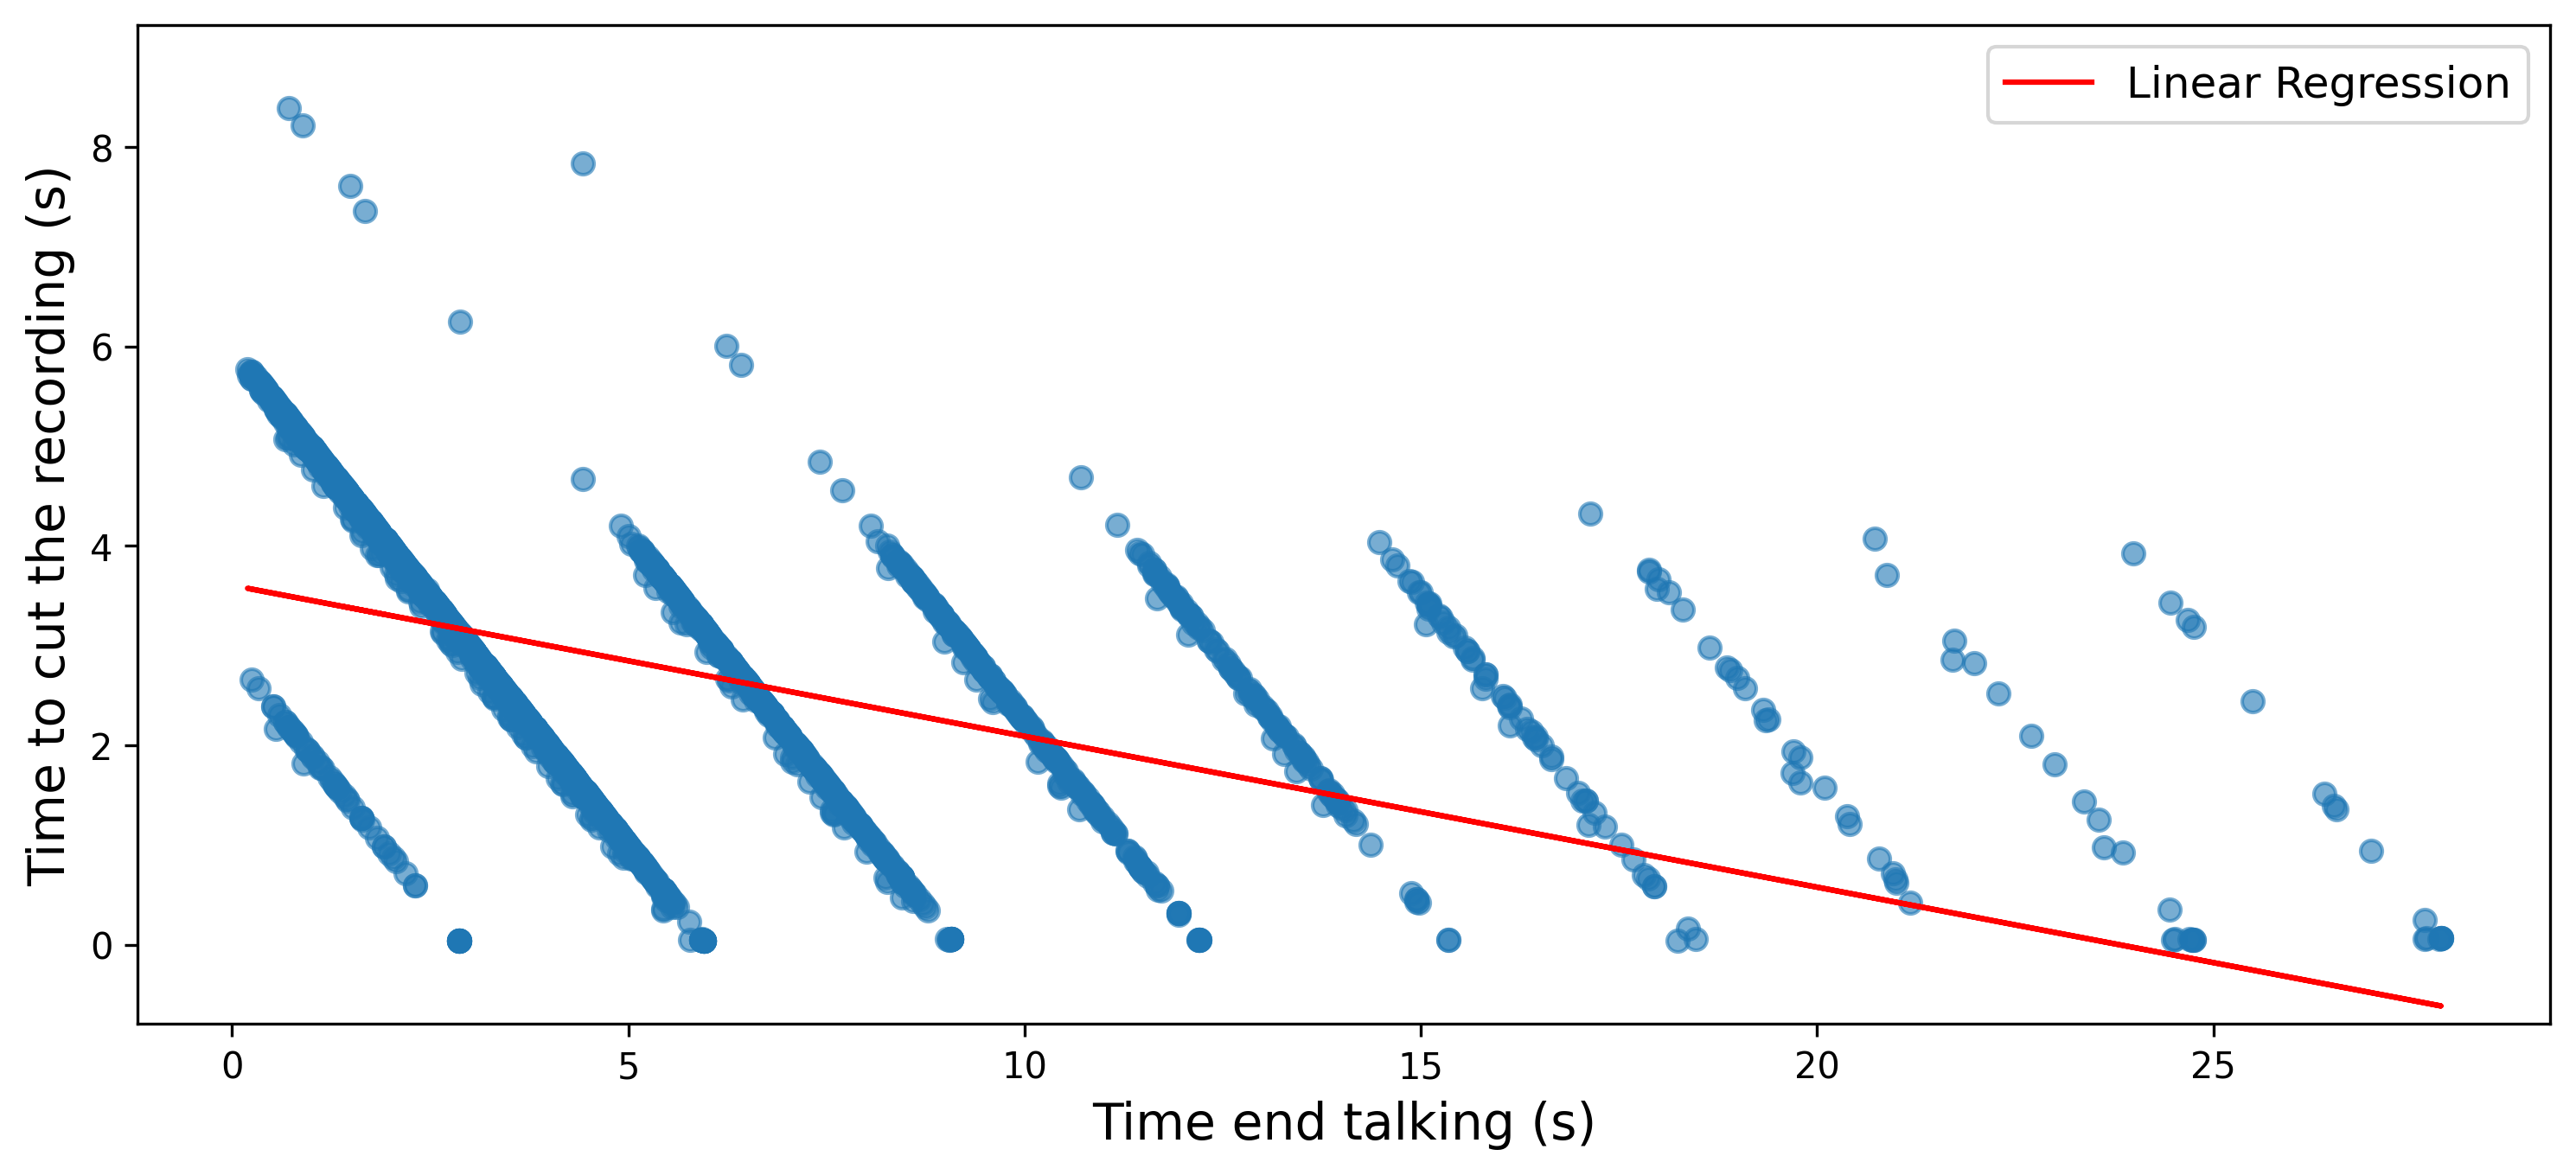

In [10]:
data=df_no_depress
x_feat="LastEnd"
x_name="Time end talking (s)"
y_feat="TimeWasteSilence"
y_name="Time to cut the recording (s)"
lr_mode = True


data_idx = data[[x_feat, y_feat]].dropna().index.values

corr_v, corr_pvalue = stats.pearsonr(data.loc[data_idx, x_feat].values, data.loc[data_idx, y_feat].values)
print("Correlation value", corr_v)
print("P-value", aute.get_p_string(corr_pvalue))

plt.figure(figsize=(12, 5), dpi=300)

if lr_mode:
    lr = linear_model.LinearRegression(n_jobs=-1)
    lr.fit(data.loc[data_idx, x_feat].values.reshape(-1, 1), data.loc[data_idx, y_feat])
    y_pred = lr.predict(data.loc[data_idx, x_feat].values.reshape(-1, 1))

    print("Coefficients: \n", lr.coef_, "\nIntercept: \n", lr.intercept_)
    print("R-square: %.2f" % r2_score(data.loc[data_idx, y_feat], y_pred))

    plt.plot(data.loc[data_idx, x_feat], y_pred, c="red", label="Linear Regression")
    plt.legend(fontsize=12)
    delta_int = np.abs(np.nanmax(data[y_feat]) - np.nanmin(data[y_feat]))
    plt.ylim(np.nanmin(data[y_feat]) - 0.1 * delta_int, np.nanmax(data[y_feat]) + 0.1 * delta_int)

plt.scatter(data[x_feat], data[y_feat], alpha=0.6)

plt.xlabel(x_name, fontsize=14)
plt.ylabel(y_name, fontsize=14)

plt.savefig("Results/EndAudiovsWaste.pdf", dpi=300, format="pdf")

Correlation value -0.4003050393417384
P-value ***
Coefficients: 
 [-0.13968544] 
Intercept: 
 3.3667737422321453
R-square: 0.16


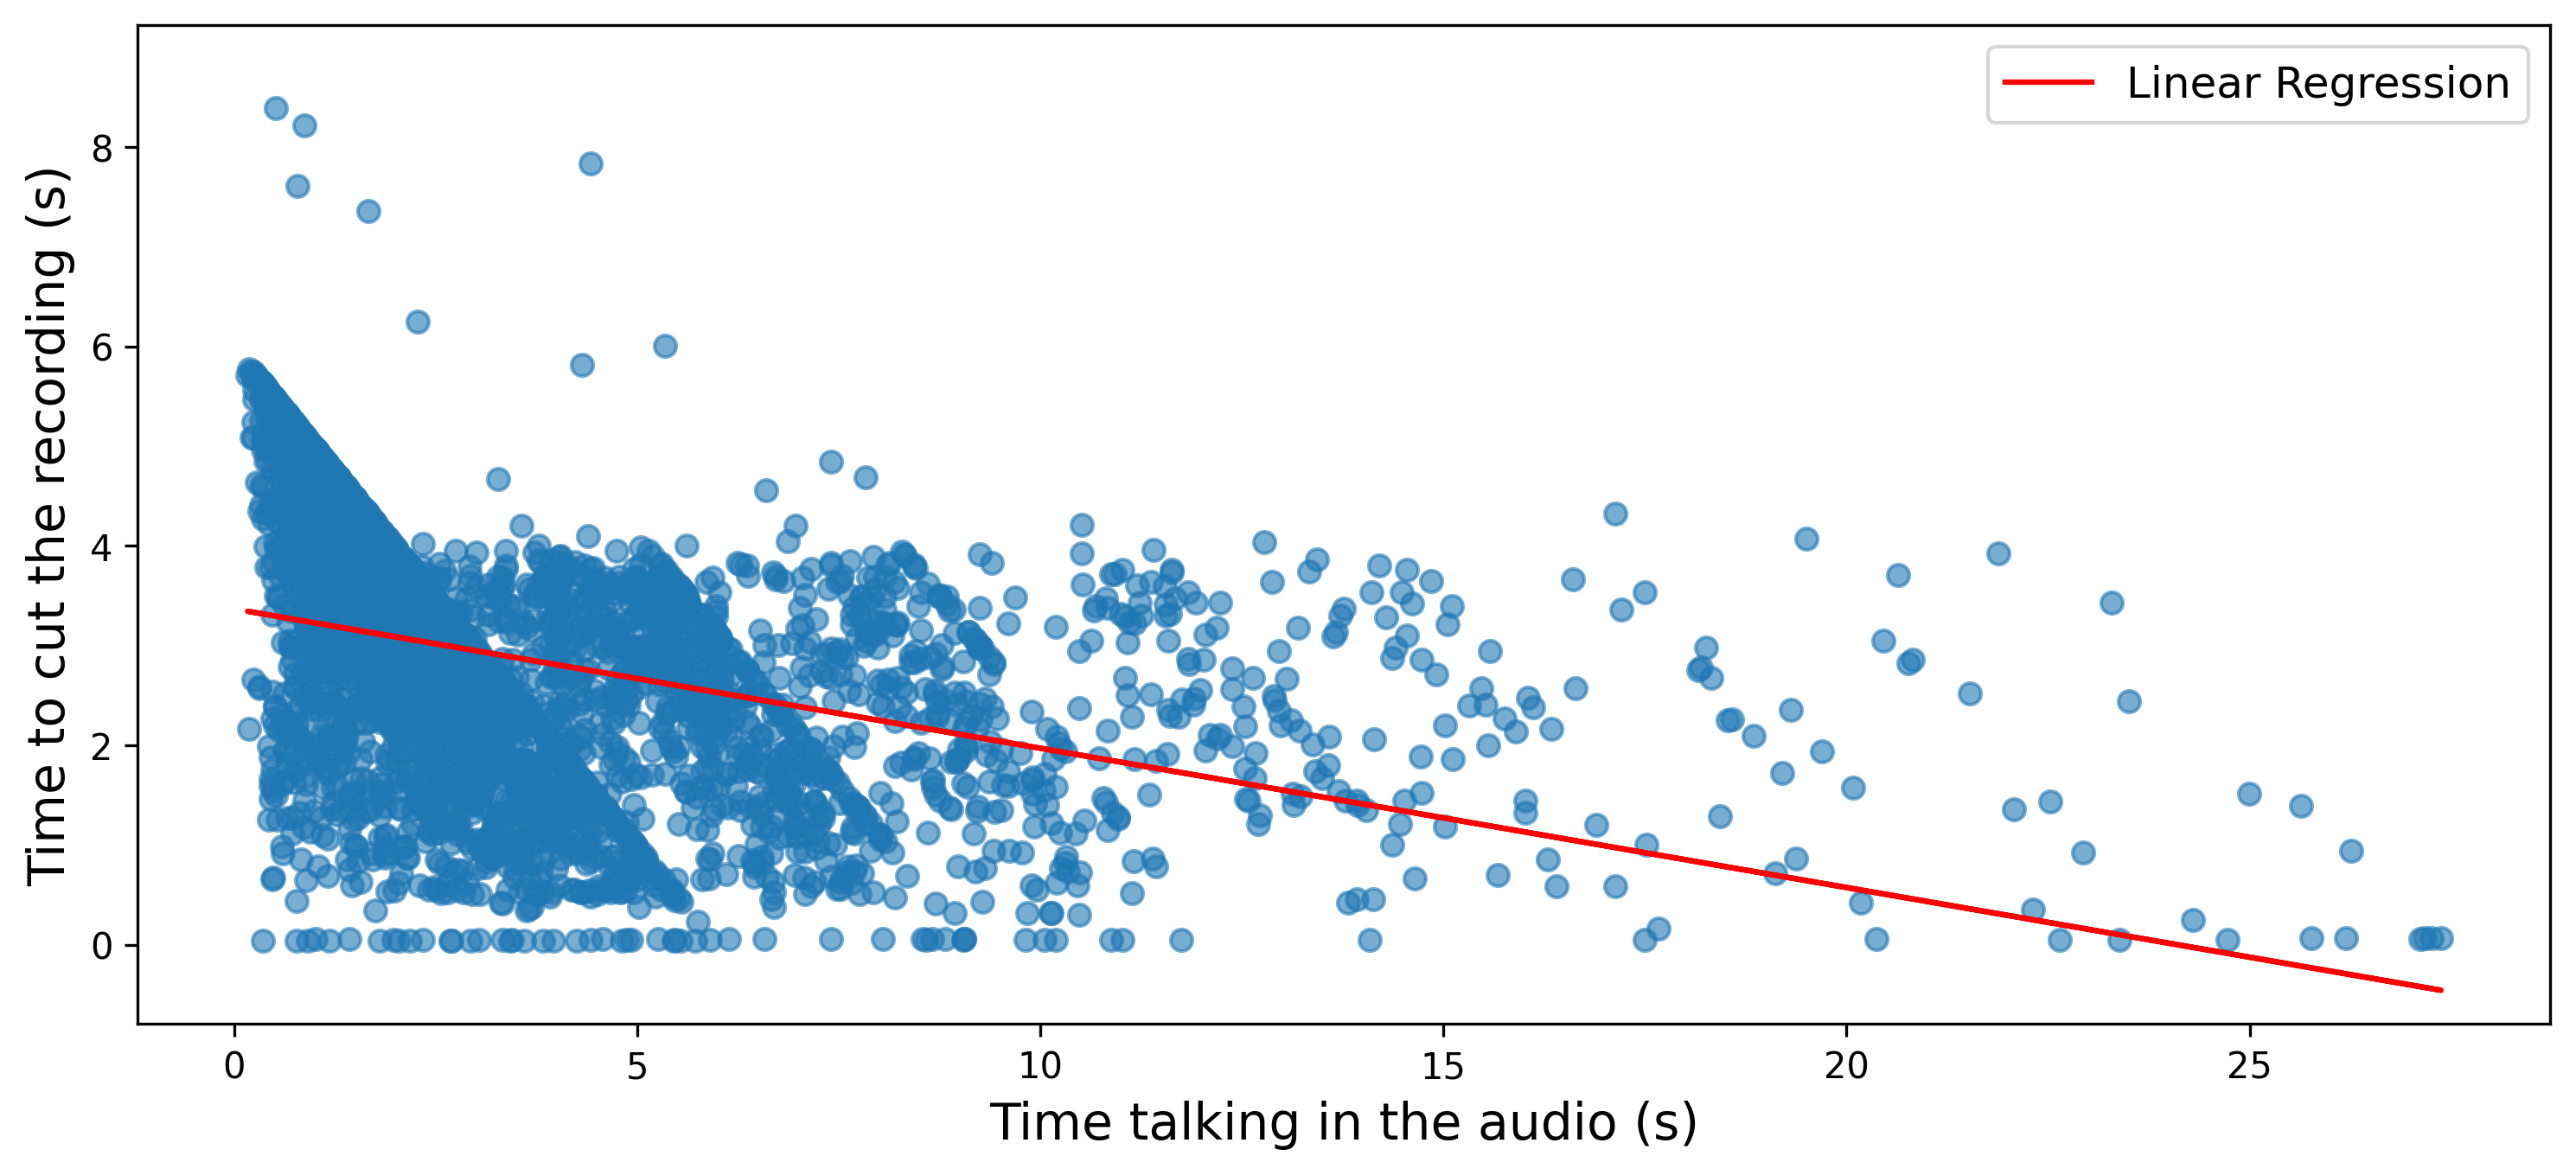

In [72]:
data=df_no_depress
x_feat="TimeTalking"
x_name="Time talking in the audio (s)"
y_feat="TimeWasteSilence"
y_name="Time to cut the recording (s)"
lr_mode = True


data_idx = data[[x_feat, y_feat]].dropna().index.values

corr_v, corr_pvalue = stats.pearsonr(data.loc[data_idx, x_feat].values, data.loc[data_idx, y_feat].values)
print("Correlation value", corr_v)
print("P-value", aute.get_p_string(corr_pvalue))

plt.figure(figsize=(12, 5), dpi=300)

if lr_mode:
    lr = linear_model.LinearRegression(n_jobs=-1)
    lr.fit(data.loc[data_idx, x_feat].values.reshape(-1, 1), data.loc[data_idx, y_feat])
    y_pred = lr.predict(data.loc[data_idx, x_feat].values.reshape(-1, 1))

    print("Coefficients: \n", lr.coef_, "\nIntercept: \n", lr.intercept_)
    print("R-square: %.2f" % r2_score(data.loc[data_idx, y_feat], y_pred))

    plt.plot(data.loc[data_idx, x_feat], y_pred, c="red", label="Linear Regression")
    plt.legend(fontsize=12)
    delta_int = np.abs(np.nanmax(data[y_feat]) - np.nanmin(data[y_feat]))
    plt.ylim(np.nanmin(data[y_feat]) - 0.1 * delta_int, np.nanmax(data[y_feat]) + 0.1 * delta_int)

plt.scatter(data[x_feat], data[y_feat], alpha=0.6)

plt.xlabel(x_name, fontsize=14)
plt.ylabel(y_name, fontsize=14)

plt.savefig("Results/TimeTalkingvsWaste.pdf", dpi=300, format="pdf")

# plt.show()